# Time Series Forecasting

## How To Predict Future Data Using ARIMA and SARIMA models

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import datetime as dt
from scipy import stats
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.regression.linear_model import yule_walker
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic, acf, pacf
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from itertools import product
import seaborn as sns
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_theme()

plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:navy', 'xkcd:lawn green', 'xkcd:cadet blue', 'xkcd:dark red', 'xkcd:dark orange', 'xkcd:terra cotta', 'xkcd:purple', 'xkcd:teal', 'xkcd:goldenrod', 
          'xkcd:crimson', 'xkcd:dark violet']

# Introduction to the dataset

ARIMA and SARIMA are used for predict future data (Forecasting).

In this code our main focus is discuss about these two models and how to do forecasting using them.

Retail Sales: Clothing and Clothing Accessory Stores. The data has been taken from the Federal Reserve Economic Data (https://fred.stlouisfed.org/series/RSCCASN#)

For the U.S., estimates of retail sales and inventories, by "kind of store" under NAICS. Monthly.

Sales include merchandise sold (for cash or credit at retail or wholesale) by establishments primarily engaged in retail trade. Services that are incidental to the sale of merchandise, and excise taxes that are paid by the manufacturer or wholesaler and passed along to the retailer, are also included. Sales are net after deductions for refunds and allowances for merchandise returned by customers. Sales exclude sales taxes collected directly from customer and paid directly to a local, state, or federal tax agency.

Unit: Millions of Dollars; Frequency: Monthly

In [3]:
data=pd.read_csv('RSCCASN.csv',parse_dates=True,index_col='DATE')
data

RSCCASN
DATE               
1992-01-01     6938
1992-02-01     7524
1992-03-01     8475
1992-04-01     9401
1992-05-01     9558
...             ...
2021-07-01    25874
2021-08-01    25745
2021-09-01    23306
2021-10-01    24944
2021-11-01    28794

[359 rows x 1 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1992-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  359 non-null    int64
dtypes: int64(1)
memory usage: 5.6 KB


<AxesSubplot:xlabel='DATE'>

<Figure size 864x576 with 0 Axes>

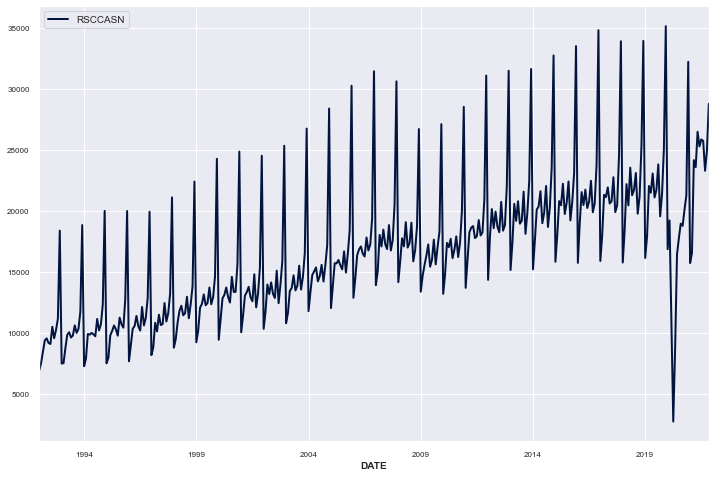

In [5]:
plt.figure()
data.plot(color=colors[0])

It show clearly, this data follow upward tread with seasonality.

We already know ARIMA Model takes assumption data is in stationary, because Forecasting a stationary series is relatively easy and the forecasts are more reliable.

In [7]:
g = px.line(data, markers=True)
g.show()

## Train and Test set

We want to make the forecast for the years 2017 and 2018

In [6]:
df = data[data.index < '2019-01-01']
train = df[df.index < '2017-01-01']
test = df[df.index >= '2017-01-01']

In [9]:
train

RSCCASN
DATE               
1992-01-01     6938
1992-02-01     7524
1992-03-01     8475
1992-04-01     9401
1992-05-01     9558
...             ...
2016-08-01    22479
2016-09-01    19904
2016-10-01    20626
2016-11-01    23800
2016-12-01    34824

[300 rows x 1 columns]

In [10]:
test

RSCCASN
DATE               
2017-01-01    15907
2017-02-01    18020
2017-03-01    21332
2017-04-01    21143
2017-05-01    21945
2017-06-01    20618
2017-07-01    20795
2017-08-01    22775
2017-09-01    19909
2017-10-01    20469
2017-11-01    24560
2017-12-01    33923
2018-01-01    15780
2018-02-01    18424
2018-03-01    22207
2018-04-01    20463
2018-05-01    23560
2018-06-01    21294
2018-07-01    21733
2018-08-01    23121
2018-09-01    19782
2018-10-01    21203
2018-11-01    25364
2018-12-01    33950

## Time Series Analysis

We analyze our time series. They are 3 types of patterns that are usually observed in time series data:
1. Trend: it describes the movement of data values either higher or lower at regular intervals of time over a long period. If the movement of data value is in the upper pattern, then it is known as an upward trend and if the movement of data value shows a lower pattern then it is known as a downward trend. If the data values show a constant movement, then is known as a horizontal trend.
2. Seasonality: it is a continuous upward and downward trend that repeat itself after a fixed interval of time.
3. Irregularity: it has no systematic pattern and occurs only for a short period of time and it does not repeat itself after a fixed interval of time. It can also be known as noise or residual.

We have to see if our time series data has stationery characteristic.

To see if our time series is stationary we can use two methods:
1. Rolling statistics: this method gave a visual representation of the data to define
its stationarity. A Moving variance or moving average graph is plotted and then it
is observed whether it varies with time or not.
2. Augmented Dickey- fuller Test (ADCF): in this method, we take a null hypothesis
that the data is non-stationary. After executing this test, it will give some results
as the test statistics and some other critical values that help to define the stationarity. If the test statistic is less than the critical value then we can reject the nullhypothesis and say that the series is stationary.

In [11]:
print("Observations of Dickey-fuller test")
dftest = adfuller(train['RSCCASN'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -0.307616
p-value                          0.924419
#lags used                      15.000000
number of observations used    284.000000
critical value (1%)             -3.453587
critical value (5%)             -2.871771
critical value (10%)            -2.572222
dtype: float64


In this case, we can't reject our null hypothesis conclude that our data is not stationary

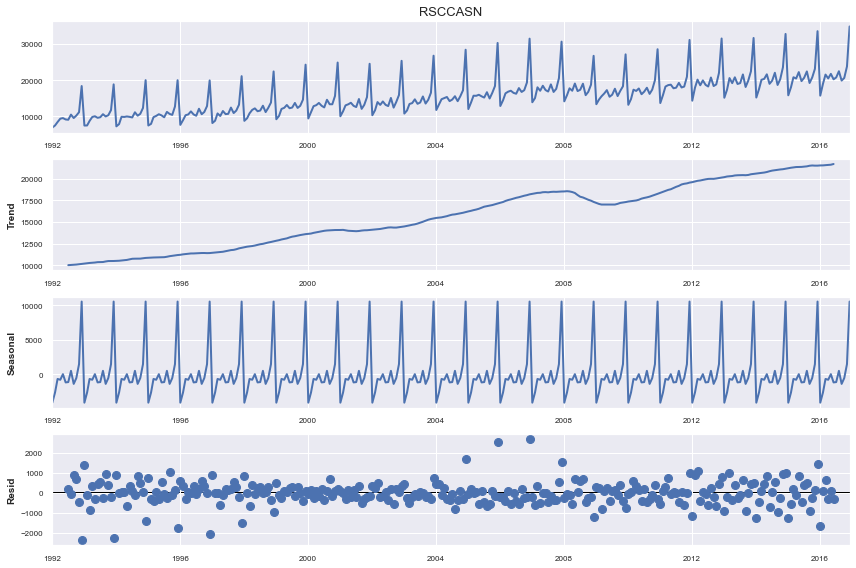

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(train['RSCCASN'].dropna(), model='additive', period =12)
result.plot()
plt.show()

There are many ways to convert non stationary data into stationary.
1. 1st difference or 2nd. or 3 rd difference (most popular method).
2. logarithm difference (we do this).

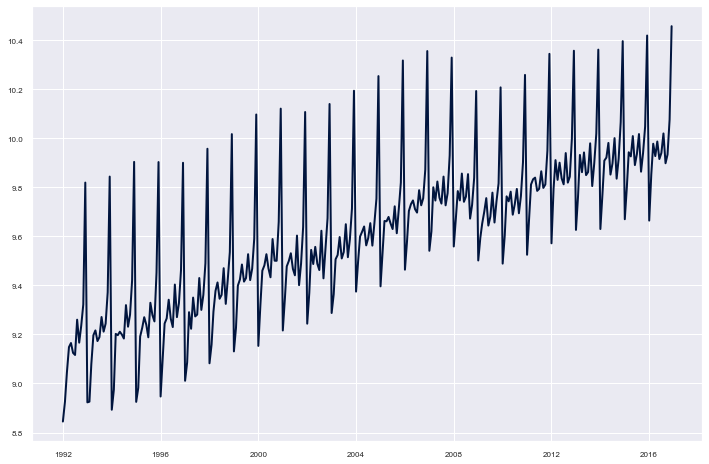

In [17]:
log_data=np.log(train['RSCCASN'])
plt.plot(log_data, color=colors[0])
plt.show()

In [19]:
print("Observations of Dickey-fuller test")
dftest = adfuller(log_data.dropna(),autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -1.082071
p-value                          0.722168
#lags used                      14.000000
number of observations used    285.000000
critical value (1%)             -3.453505
critical value (5%)             -2.871735
critical value (10%)            -2.572202
dtype: float64


Even after applying the Log Tansform to the dataset, the data appears to be in non-stationary form

In [21]:
Train_log_first_difference = np.log(train['RSCCASN']) - np.log(train['RSCCASN']).shift(1)

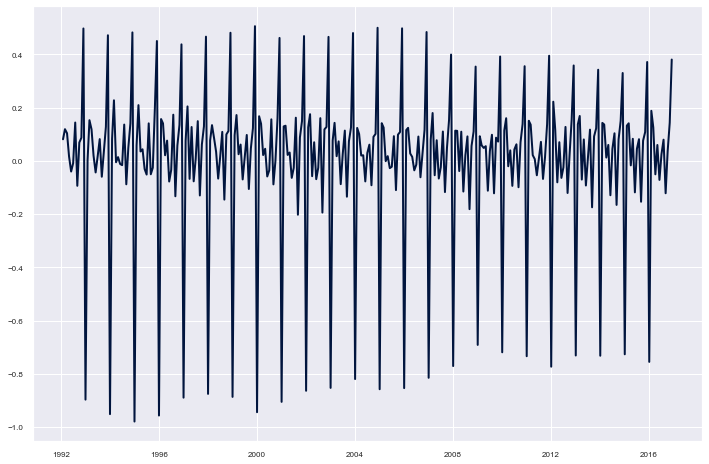

In [22]:
plt.plot(Train_log_first_difference, color=colors[0])
plt.show()

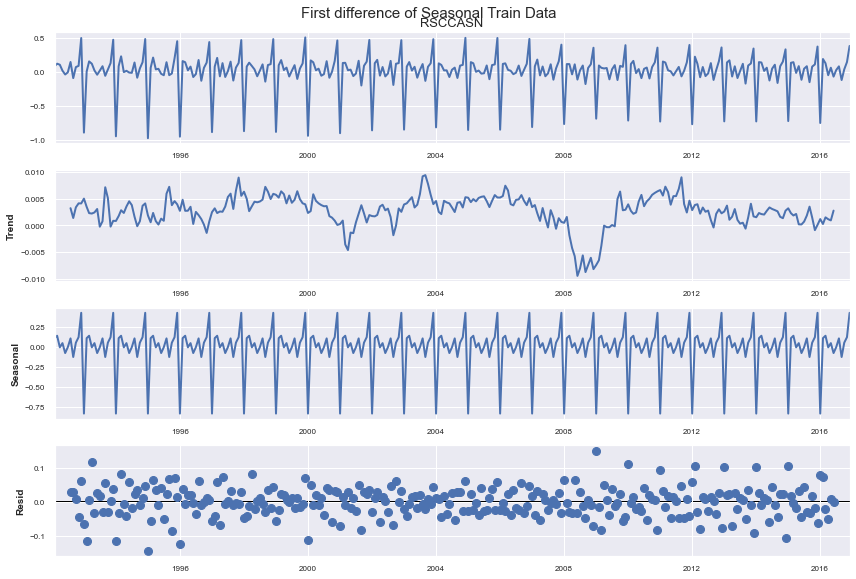

In [23]:
#Seasonal Decomposition
result2=seasonal_decompose(Train_log_first_difference.dropna(), model='additive', period =12)
result2.plot()
plt.suptitle('First difference of Seasonal Train Data', y=1)
plt.show()

We can see that we have reduced a lot of seasonality and trend. We can also proceed for adfuller test where we can compare the p-value.

Let's see if we made the time series stationary.

In [24]:
print("Observations of Dickey-fuller test")
dftest = adfuller(Train_log_first_difference.dropna(),autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -3.703519
p-value                          0.004064
#lags used                      13.000000
number of observations used    285.000000
critical value (1%)             -3.453505
critical value (5%)             -2.871735
critical value (10%)            -2.572202
dtype: float64


We can see that the p-value is less than 0.05. Now our time series is stationary.

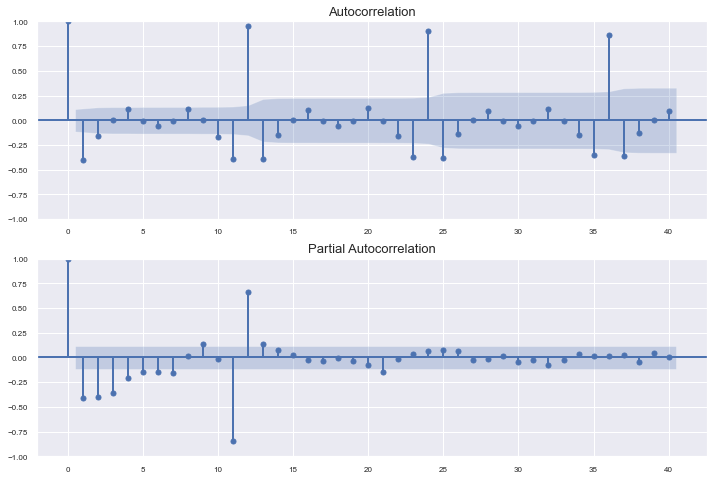

In [25]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(Train_log_first_difference.dropna(), lags=40, ax=ax[0]) 
fig = sm.graphics.tsa.plot_pacf(Train_log_first_difference.dropna(), lags=40, ax=ax[1], method='ywm')
plt.show()

From the figure above, we expect p in range(0,2), d in range(0,2) and q in range(1,4)

## ARIMA

In statistics and in time series analysis, an  ARIMA (autoregressive integrated moving average) model is an update of ARMA (autoregressive moving average). The ARMA consists of mainly two components, the autoregressive and moving average; the ARIMA consists of an integrated moving average of autoregressive time series.  ARIMA model is useful in the cases where the time series is non-stationary. And the differencing is required to make the time series stationary. 

AR(p) stands for the auto regressive model, the p parameter is an integer that confirms how many lagged series are going to be used to forecast periods ahead. An autoregressive process, of order p, is a process in which the series {yt} is a weighted sum of p past variables plus a white noise error term

I(d) is the differencing part, the d parameter tells how many differencing orders are going to be used to make the series stationary.

MA(q) stands for moving average model, the q is the number of lagged forecast error terms in the prediction equation. MA(q) models are always stationary as they are finite, linear combination of white noise processes.

ARIMA model is best for predict forecasting, when the data is not seasonal.

In [27]:
model_arima= auto_arima(np.log(train['RSCCASN']), start_p=0, d=None, start_q=0, max_p=5, max_d=3, max_q=5, seasonal= True, information_criterion= 'aic', trace= True, stepwise= False, n_jobs=8)


Best model:  ARIMA(0,1,4)(0,0,0)[1] intercept
Total fit time: 4.524 seconds


The advantage of using Auto ARIMA over the ARIMA model (it is true for SARIMA too) is that after data preprocessing step we can skip the next steps & directly fit our model. It uses the AIC (Akaike Information Criterion) & BIC (Bayesian Information Criterion) values generated by trying different combinations of p,q & d values to fit the model.

AIC is a statistical measure that we can use to compare different models for their relative quality. It measures the quality of the model in terms of its goodness-of-fit to the data and how much it relies on the tuning parameters. The formula for AIC is: 2k-2l, where l is a log-likelihood, and k is a number of parameters. AIC prefers a higher log-likelihood that indicates how strong the model is in fitting the data and a simpler model in terms of parameters.

In [30]:
arima_model = sm.tsa.statespace.SARIMAX(np.log(train.RSCCASN), order=(0,1,4)).fit()
arima_model.summary()

Optimization terminated successfully.
         Current function value: -0.247598
         Iterations: 8
         Function evaluations: 510


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                RSCCASN   No. Observations:                  300
Model:               SARIMAX(0, 1, 4)   Log Likelihood                  74.279
Date:                Mon, 10 Jan 2022   AIC                           -138.559
Time:                        16:28:41   BIC                           -120.056
Sample:                    01-01-1992   HQIC                          -131.153
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1501      0.085    -13.544      0.000      -1.316      -0.984
ma.L2         -0.1920      0.161     -1.191      0.234      -0.508       0.124
ma.L3          0.1651      0.199      0.830      0.406      -0.225       0.555
ma.L4          0.2753      0.108      2.545      0.011       0.063       0.487
sigma2         0.0350      0.003     13.843      0.000       0.030       0.040
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               350.09
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             1.88
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We need to check the residuals. We want to make sure our model meets the assumption that the residuals are independent, known as white noise.

If the residuals are not independent, we can extract out the non-randomness to make a better model.

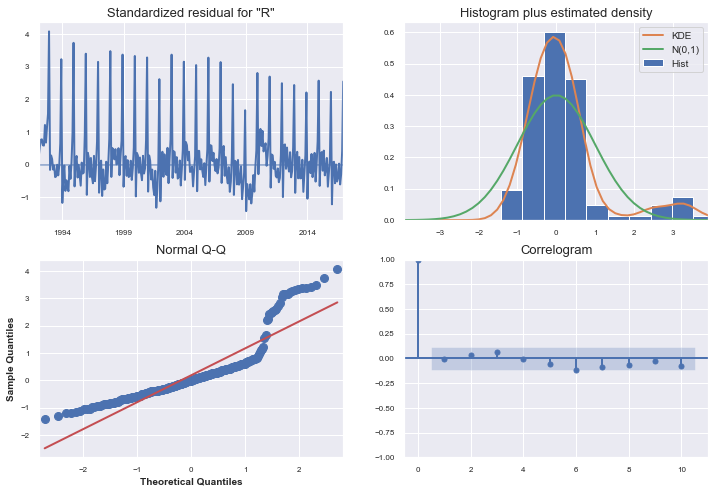

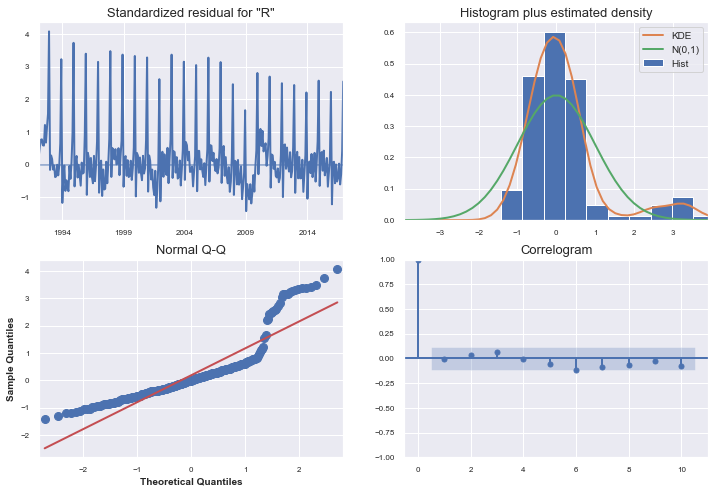

In [34]:
arima_model.plot_diagnostics()

$\textbf{Histogram plus estimated density plot}$: The red KDE line doesn't follow the N(0,1) line. This is a good indication that the residuals aren't normally distributed.

$\textbf{The Q-Q-plot}$: Shows that the ordered distribution of residuals (blue dots) doesn't follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is an indication that the residuals aren't normally distributed.

$\textbf{The standardize residual plot}$: The residuals over time display an obvious seasonality.

$\textbf{The Correlogram plot}$: Shows that the time series residuals have low correlation with lagged versions of itself.

In [37]:
def unlog_pred(log_pred):
    
    pred = [math.exp(i) for i in log_pred.values]
    pred = pd.Series(pred, index = log_pred.index)
    
    return pred
pred_forecast_log_arima = arima_model.get_forecast(steps = len(test))
pred_forecast_arima = unlog_pred(pred_forecast_log_arima.predicted_mean)

test['Prediction ARIMA']=pred_forecast_arima

In [38]:
test

RSCCASN  Prediction ARIMA
DATE                                 
2017-01-01    15907      19055.556247
2017-02-01    18020      17349.012984
2017-03-01    21332      19172.580164
2017-04-01    21143      21858.595871
2017-05-01    21945      21858.595871
2017-06-01    20618      21858.595871
2017-07-01    20795      21858.595871
2017-08-01    22775      21858.595871
2017-09-01    19909      21858.595871
2017-10-01    20469      21858.595871
2017-11-01    24560      21858.595871
2017-12-01    33923      21858.595871
2018-01-01    15780      21858.595871
2018-02-01    18424      21858.595871
2018-03-01    22207      21858.595871
2018-04-01    20463      21858.595871
2018-05-01    23560      21858.595871
2018-06-01    21294      21858.595871
2018-07-01    21733      21858.595871
2018-08-01    23121      21858.595871
2018-09-01    19782      21858.595871
2018-10-01    21203      21858.595871
2018-11-01    25364      21858.595871
2018-12-01    33950      21858.595871

In [43]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return({'mape':mape, 'corr':corr, 'RMSE':rmse})

In [44]:
forecast_accuracy(test['RSCCASN'], test['Prediction ARIMA'])

{'mape': 0.11873063136246188,
 'corr': 0.31817783154474216,
 'RMSE': 4064.611046992451}

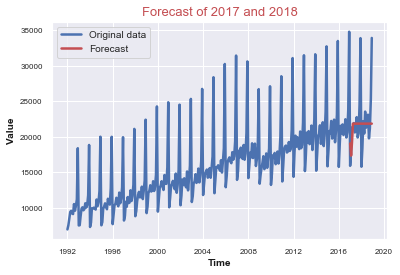

In [47]:
plt.figure()
plt.plot(df['RSCCASN'], 'b', label= 'Original data', linewidth = 2.5)
plt.plot(test['Prediction ARIMA'], 'r', label= 'Forecast', linewidth = 2.5)
plt.xlabel('Time', color='k')
plt.ylabel('Value', color='k')
plt.title('Forecast of 2017 and 2018', color= 'r')
plt.legend()
plt.show()

It's not good.

# SARIMA

SARIMA is seasonal ARIMA and it is used with predict time series with seasonality. p,d,q is the same of ARIMA
P,D,Q is the analog version of p,d,q.

P: Seasonal autoregressive order.

D: Seasonal difference order.

Q: Seasonal moving average order.

m: The number of time steps for a single seasonal period.

In [7]:
Train_log_seasonal_difference = np.log(train['RSCCASN']) - np.log(train['RSCCASN']).shift(12)

In [8]:
print("Observations of Dickey-fuller test")
dftest = adfuller(Train_log_seasonal_difference.dropna(),autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -3.058440
p-value                          0.029786
#lags used                      15.000000
number of observations used    272.000000
critical value (1%)             -3.454622
critical value (5%)             -2.872225
critical value (10%)            -2.572464
dtype: float64


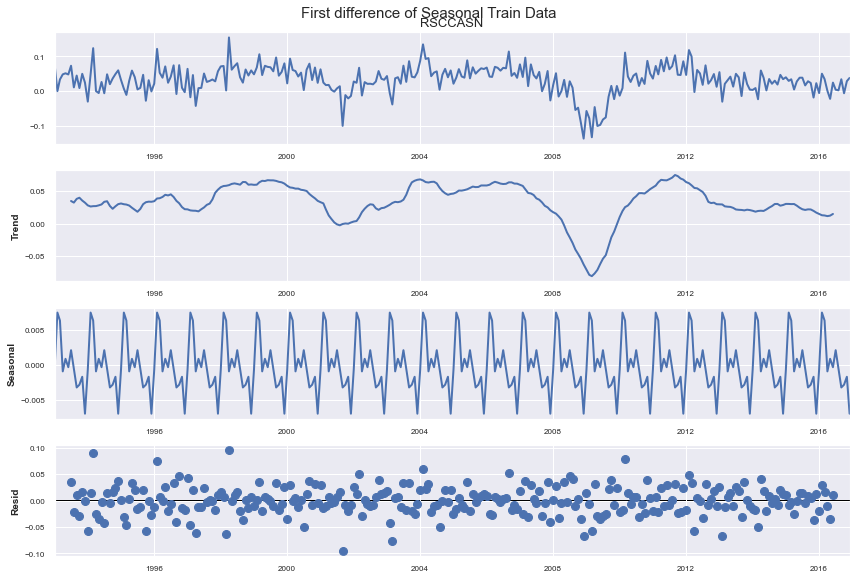

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Seasonal Decomposition
result2=seasonal_decompose(Train_log_seasonal_difference.dropna(), model='additive', period =12)
result2.plot()
plt.suptitle('First difference of Seasonal Train Data', y=1)
plt.show()

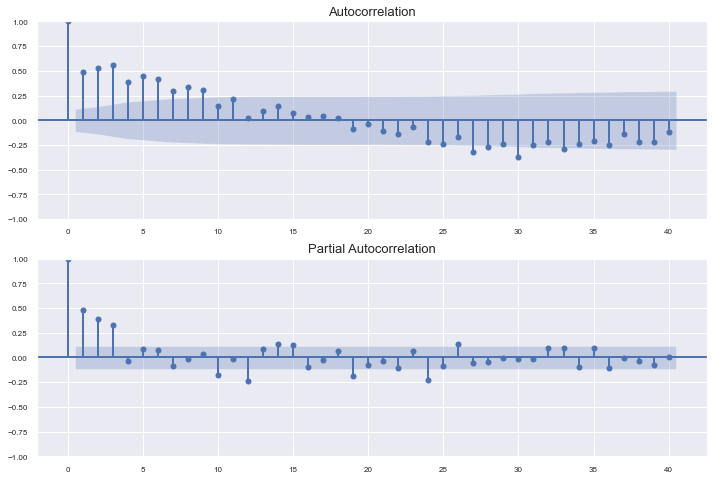

In [11]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(Train_log_seasonal_difference.dropna(), lags=40, ax=ax[0]) 
fig = sm.graphics.tsa.plot_pacf(Train_log_seasonal_difference.dropna(), lags=40, ax=ax[1], method='ywm')
plt.show()

We expect p=3, q=0, d=0

In [48]:
model_sarima= auto_arima(train['RSCCASN'], start_p=0, d=None, start_q=0, max_p=10, max_d=4, max_q=10, start_P=0, D=None, start_Q=0,
                 max_P=10, max_D=4, max_Q=10,  m=12, seasonal= True, information_criterion= 'aic', trace= True, stepwise= False, n_jobs=8)


Best model:  ARIMA(3,0,0)(1,1,1)[12] intercept
Total fit time: 38.697 seconds


In [49]:
sar = sm.tsa.statespace.SARIMAX(np.log(train.RSCCASN), 
                                order=(3,0,0), 
                                seasonal_order=(1,1,1,12)).fit()
sar.summary()

Optimization terminated successfully.
         Current function value: -2.025870
         Iterations: 4
         Function evaluations: 334


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              RSCCASN   No. Observations:                  300
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 607.761
Date:                              Mon, 10 Jan 2022   AIC                          -1203.522
Time:                                      16:39:09   BIC                          -1181.544
Sample:                                  01-01-1992   HQIC                         -1194.714
                                       - 12-01-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2304      0.054      4.276      0.000       0.125       0.336
ar.L2          0.3136      0.056      5.565      0.000       0.203       0.424
ar.L3          0.4198      0.057      7.376      0.000       0.308       0.531
ar.S.L12       0.0863      0.137      0.630      0.529      -0.182       0.355
ma.S.L12      -0.5456      0.122     -4.454      0.000      -0.786      -0.305
sigma2         0.0008    5.8e-05     14.585      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.66
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.01
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We need to check the residuals.

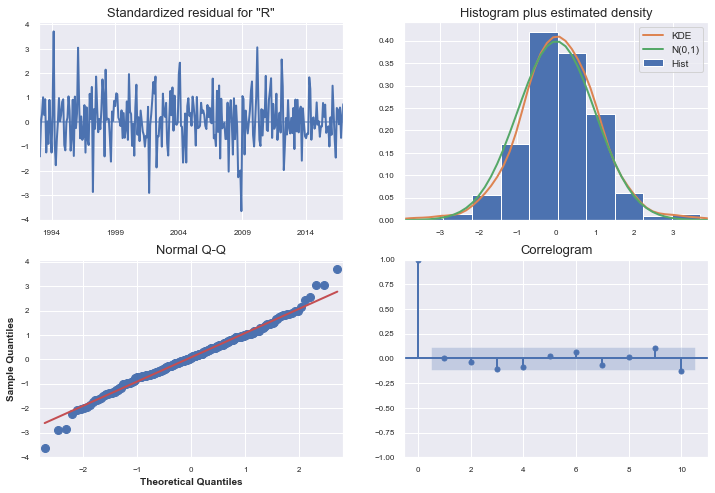

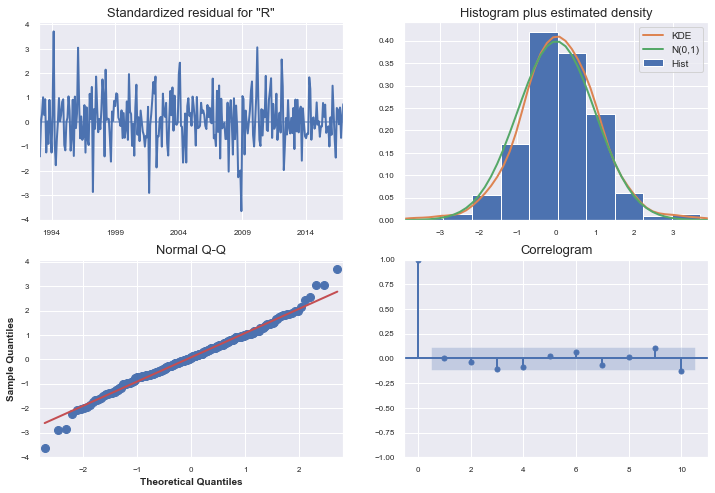

In [53]:
sar.plot_diagnostics()

$\textbf{Histogram plus estimated density plot}$: The red KDE line follows closely with the N(0,1) line. This is a good indication that the residuals are normally distributed.

$\textbf{The Q-Q-plot}$: Shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is an indication that the residuals are normally distributed.

$\textbf{The standardize residual plot}$: The residuals over time don’t display any obvious seasonality and appear to be white noise.

$\textbf{The Correlogram plot}$: Shows that the time series residuals have low correlation with lagged versions of itself.

In [54]:
pred_forecast_log_sar = sar.get_forecast(steps = len(test))
pred_forecast_sar = unlog_pred(pred_forecast_log_sar.predicted_mean)

test['Prediction SARIMA']=pred_forecast_sar

In [55]:
forecast_accuracy(test['RSCCASN'], test['Prediction SARIMA'])

{'mape': 0.024476591219940235,
 'corr': 0.9910210688580524,
 'RMSE': 678.1113037749346}

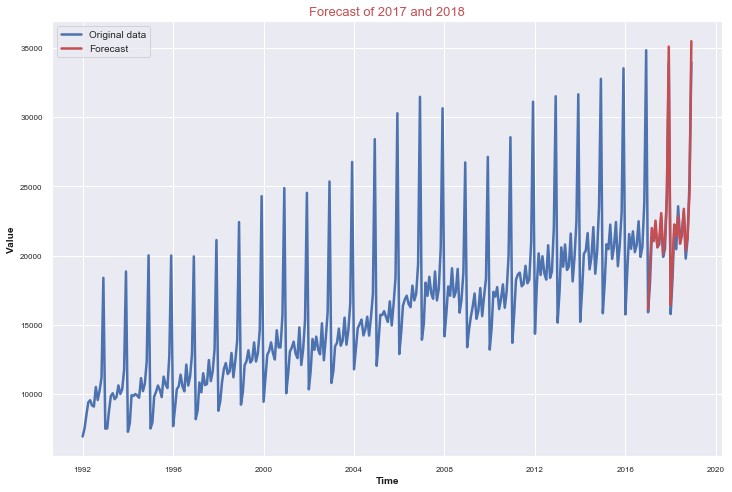

In [56]:
plt.figure()
plt.plot(df['RSCCASN'], 'b', label= 'Original data', linewidth = 2.5)
plt.plot(test['Prediction SARIMA'], 'r', label= 'Forecast', linewidth = 2.5)
plt.xlabel('Time', color='k')
plt.ylabel('Value', color='k')
plt.title('Forecast of 2017 and 2018', color= 'r')
plt.legend()
plt.show()

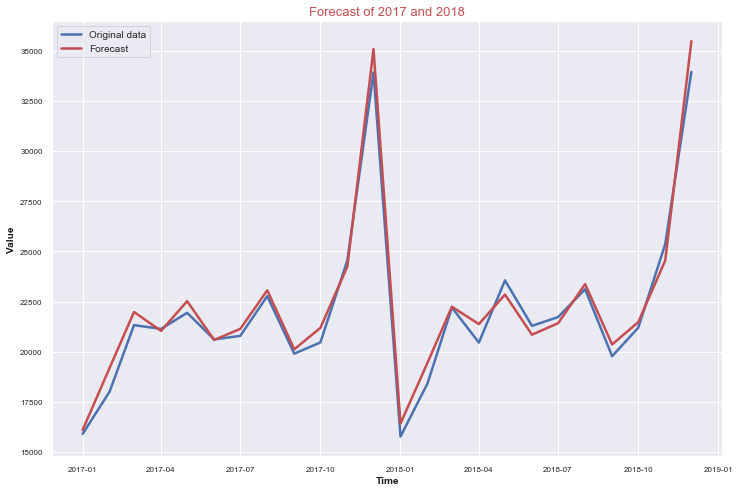

In [57]:
plt.figure()
plt.plot(df['RSCCASN'][-len(test):], 'b', label= 'Original data', linewidth = 2.5)
plt.plot(test['Prediction SARIMA'], 'r', label= 'Forecast', linewidth = 2.5)
plt.xlabel('Time', color='k')
plt.ylabel('Value', color='k')
plt.title('Forecast of 2017 and 2018', color= 'r')
plt.legend()
plt.show()

SARIMA works very well. However, it can happen that a pandemic destroys all forecasts made

# Forecasts during the years of the pandemic COVID-19

In [61]:
train_C19 = data[data.index < '2019-01-01']
test_C19 = data[data.index >= '2019-01-01']

In [62]:
train_C19

RSCCASN
DATE               
1992-01-01     6938
1992-02-01     7524
1992-03-01     8475
1992-04-01     9401
1992-05-01     9558
...             ...
2018-08-01    23121
2018-09-01    19782
2018-10-01    21203
2018-11-01    25364
2018-12-01    33950

[324 rows x 1 columns]

In [63]:
test_C19

RSCCASN
DATE               
2019-01-01    16155
2019-02-01    17961
2019-03-01    22059
2019-04-01    21500
2019-05-01    23079
2019-06-01    21116
2019-07-01    21742
2019-08-01    23829
2019-09-01    19567
2019-10-01    21400
2019-11-01    25170
2019-12-01    35157
2020-01-01    16873
2020-02-01    19232
2020-03-01    10969
2020-04-01     2744
2020-05-01     8787
2020-06-01    16442
2020-07-01    17779
2020-08-01    18968
2020-09-01    18790
2020-10-01    20088
2020-11-01    21287
2020-12-01    32237
2021-01-01    15740
2021-02-01    16568
2021-03-01    24171
2021-04-01    23599
2021-05-01    26503
2021-06-01    25301
2021-07-01    25874
2021-08-01    25745
2021-09-01    23306
2021-10-01    24944
2021-11-01    28794

In [64]:
print("Observations of Dickey-fuller test")
dftest = adfuller(train_C19['RSCCASN'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -0.623430
p-value                          0.865599
#lags used                      14.000000
number of observations used    309.000000
critical value (1%)             -3.451691
critical value (5%)             -2.870939
critical value (10%)            -2.571778
dtype: float64


In [65]:
Train_log_first_difference_C19 = np.log(train_C19['RSCCASN']) - np.log(train_C19['RSCCASN']).shift(1)

In [68]:
dftest = adfuller(Train_log_first_difference_C19.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -3.9509585446071074
2. P-Value :  0.0016902366356817738
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 309
5. Critical Values :
	 1% :  -3.45169128009473
	 5% :  -2.8709394227049154
	 10% :  -2.5717780602423517


In [71]:
model_sarima_C19= auto_arima(train['RSCCASN'], start_p=0, d=None, start_q=0, max_p=10, max_d=4, max_q=10, start_P=0, D=None, start_Q=0,
                 max_P=10, max_D=4, max_Q=10,  m=12, seasonal= True, information_criterion= 'aic', trace= True, stepwise= False, n_jobs=8)


Best model:  ARIMA(3,0,0)(1,1,1)[12] intercept
Total fit time: 35.001 seconds


In [72]:
sar_C19 = sm.tsa.statespace.SARIMAX(np.log(train.RSCCASN), 
                                order=(3,0,0), 
                                seasonal_order=(1,1,1,12)).fit(method = 'powell')
sar_C19.summary()

Optimization terminated successfully.
         Current function value: -2.034331
         Iterations: 4
         Function evaluations: 339


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              RSCCASN   No. Observations:                  324
Model:             SARIMAX(3, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 659.123
Date:                              Mon, 10 Jan 2022   AIC                          -1306.247
Time:                                      16:51:45   BIC                          -1283.789
Sample:                                  01-01-1992   HQIC                         -1297.271
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2319      0.052      4.446      0.000       0.130       0.334
ar.L2          0.3125      0.054      5.822      0.000       0.207       0.418
ar.L3          0.4164      0.056      7.473      0.000       0.307       0.526
ar.S.L12       0.0756      0.133      0.570      0.569      -0.185       0.336
ma.S.L12      -0.5406      0.120     -4.509      0.000      -0.776      -0.306
sigma2         0.0008   5.65e-05     14.936      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                14.39
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We need to check the residuals.

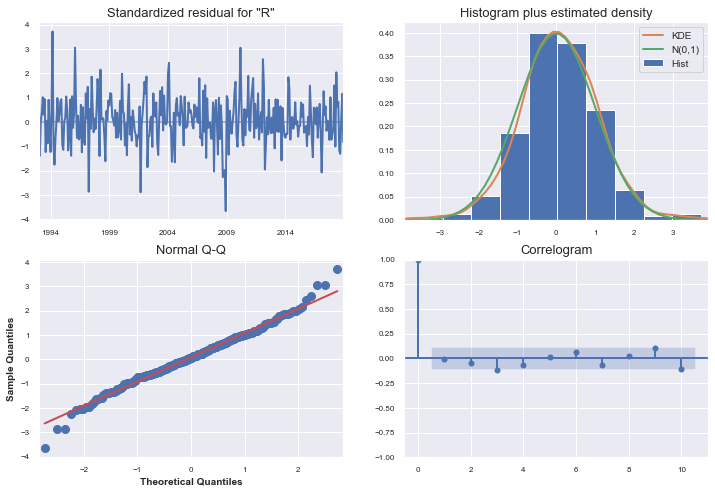

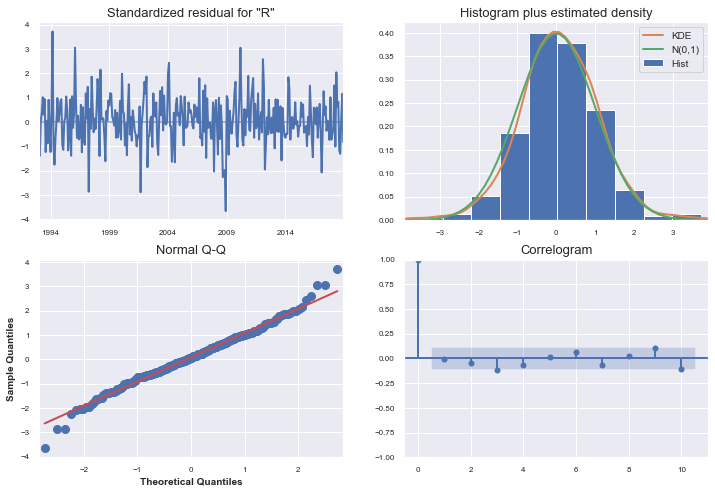

In [73]:
sar_C19.plot_diagnostics()

$\textbf{Histogram plus estimated density plot}$: The red KDE line follows closely with the N(0,1) line. This is a good indication that the residuals are normally distributed.

$\textbf{The Q-Q-plot}$: Shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is an indication that the residuals are normally distributed.

$\textbf{The standardize residual plot}$: The residuals over time don’t display any obvious seasonality and appear to be white noise.

$\textbf{The Correlogram plot}$: Shows that the time series residuals have low correlation with lagged versions of itself.

In [75]:
pred_forecast_log_C19 = sar_C19.get_forecast(steps = len(test))
pred_forecast_sar_C19 = unlog_pred(pred_forecast_log_C19.predicted_mean)

test['Prediction SARIMA C-19']=pred_forecast_sar_C19

In [76]:
forecast_accuracy(test['RSCCASN'], test['Prediction SARIMA C-19'])

{'mape': 0.12970371434339714,
 'corr': 0.6055183731242972,
 'RMSE': 4986.529652713922}

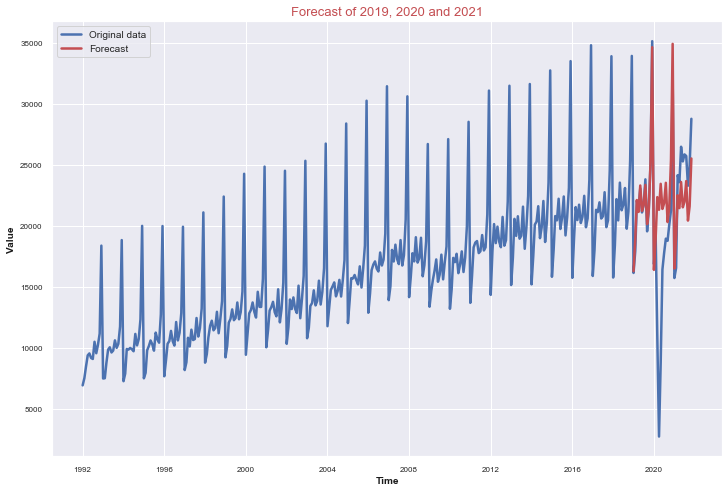

In [77]:
plt.figure()
plt.plot(data['RSCCASN'], 'b', label= 'Original data', linewidth = 2.5)
plt.plot(test['Prediction SARIMA C-19'], 'r', label= 'Forecast', linewidth = 2.5)
plt.xlabel('Time', color='k')
plt.ylabel('Value', color='k')
plt.title('Forecast of 2019, 2020 and 2021', color= 'r')
plt.legend()
#plt.savefig('Forecast SARIMA C-19.jpg', format= 'jpeg')
plt.show()

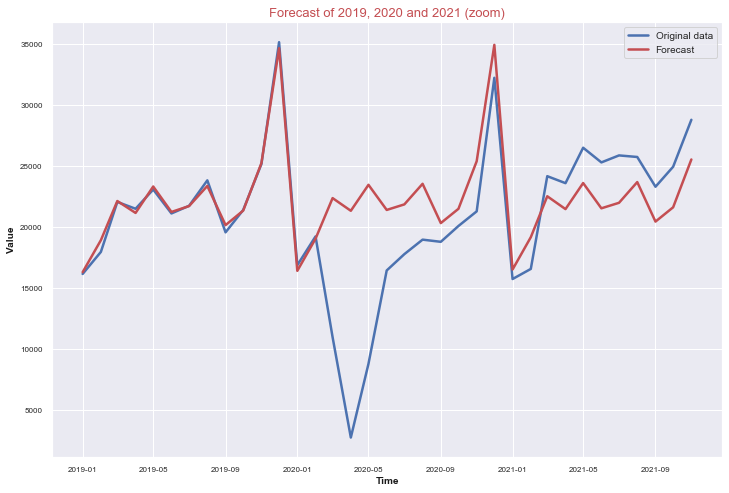

In [78]:
plt.figure()
plt.plot(data['RSCCASN'][-len(test):], 'b', label= 'Original data', linewidth = 2.5)
plt.plot(test['Prediction SARIMA C-19'], 'r', label= 'Forecast', linewidth = 2.5)
plt.xlabel('Time', color='k')
plt.ylabel('Value', color='k')
plt.title('Forecast of 2019, 2020 and 2021 (zoom)', color= 'r')
plt.legend()
plt.show()